# Capstone Project : Random Forest

In this notebook, we build a Random Forest classifier to predict the likelihood of churn given customer demographics, customer account information and customer services.

In [3]:
# Import Packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from pylab import rcParams
import math

from imblearn.pipeline import Pipeline as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, cohen_kappa_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from yellowbrick.classifier import DiscriminationThreshold

import warnings
warnings.filterwarnings('ignore')


# global set
pd.set_option('display.max_columns', None)

In [4]:
#Define the plot Function
def result(model, X_train, y_train, X_test, y_test, train_result, clf_name):
    """ This function calculates different metrics to show the model's performance on both training and test data.
    This functoin also shows the confusion matrix, and plots the ROC and PR curves.
    
    Parameters
    ----------
    model (dtype: sklearn.model_selection._search.GridSearchCV) : The classifier model
    train_result (dtype: boolean): If YES, calculate results for train data
    clf_name (dtype: str): Name of the classifier
    """
    if train_result:
        y_pred_train = model.predict(X_train) # class prediction
        y_pred_train_prob = model.predict_proba(X_train) # probability of each class prediction
        print("#####################")
        print("Train data")
        print("#####################")
        print("F1: ", metrics.f1_score(y_train, y_pred_train))
        print("Cohen Kappa: ", metrics.cohen_kappa_score(y_train, y_pred_train))
        print("Brier: ", metrics.brier_score_loss(y_train, y_pred_train))
        print("LogLoss: ", metrics.log_loss(y_train, y_pred_train_prob))
        print(metrics.classification_report(y_train, y_pred_train))
        print(metrics.confusion_matrix(y_train, y_pred_train))
    else:
        pass
    
    y_pred_test = model.predict(X_test)
    y_pred_test_prob = model.predict_proba(X_test)
    print("#####################")
    print("Test data")
    print("#####################")
    print("F1: ", metrics.f1_score(y_test, y_pred_test))
    print("Cohen Kappa: ", metrics.cohen_kappa_score(y_test, y_pred_test))
    print("Brier: ", metrics.brier_score_loss(y_test, y_pred_test))
    print("LogLoss: ", metrics.log_loss(y_test, y_pred_test_prob))
    print(metrics.classification_report(y_test, y_pred_test))
    conf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Displaying the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', fontsize=24)

    plt.title('Confusion Matrix for %s' % clf_name, size=20)
    plt.xlabel('Predicted label', size=20)
    plt.ylabel('True label', size=20)
    ax.tick_params('x', labelsize = 20)
    ax.tick_params('y', labelsize = 20)
    plt.tight_layout()
    
    # ROC curve
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='Model Performance (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], 
             [0, 1], 
             '--', 
             color=(0.6, 0.6, 0.6), 
             label='Luck')
    
    plt.plot([0, 0, 1], 
             [0, 1, 1], 
             lw=2,
             linestyle=':',
             color='black',
             label='Perfect Performance')
        
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.title('Receiver Operating Characteristic for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="lower right", fontsize=18)
    
    # PR curve
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    prec, recall, thresholds = precision_recall_curve(y_test, y_pred_test_prob[:, 1])
    #pr_auc = auc(prec, recall)
    plt.plot(recall, prec, lw=1, label='Model Performance (area = %0.2f)' % 
             (metrics.average_precision_score(y_test, y_pred_test_prob[:, 1])))    
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall', size=20)
    plt.ylabel('Precision', size=20)
    plt.title('PR Curve for %s' % clf_name, size=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.legend(loc="top right", fontsize=18)

# Preprocessing the Data
We have acquired and cleaned the data in this IPython Notebook. All the features were used for this analysis. Let's get the data prepared for modeling.

In [5]:
# global set
pd.set_option('display.max_columns', None)

# Load the data
telco = pd.read_csv("telco_eda.csv") 

# recode the features
# tranform to dummy variable
binvar = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
          'PaperlessBilling', 'Churn']
for col in binvar:
    telco[col] = telco[col].apply(lambda x: 1 if x=='Yes' else 0 )
    
transformed_telco = pd.get_dummies(telco)
transformed_telco.shape

# Train/test split
X = transformed_telco.drop(["Churn"], axis=1).values
y = transformed_telco.Churn.astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify = y)

# Random Forest - Random Under Sampling, Scaling 

In [9]:
%%time

# Steps for pipeline
steps = [("rus", RandomUnderSampler(random_state=30)),
         ("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", RandomForestClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50, 70, 100, 200, 500, 700, 1000],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [5, 10, 15])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
RFrus   = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 3,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
RFrus.fit(X_train, y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  3.4min finished


CPU times: user 1.72 s, sys: 142 ms, total: 1.86 s
Wall time: 3min 25s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rus',
                                        RandomUnderSampler(random_state=30,
                                                           replacement=False,
                                                           sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=...
                                                               n_estimators=100,
                                               

In [10]:
RFrus.best_params_

{'model__max_features': 'log2',
 'model__min_samples_leaf': 15,
 'model__n_estimators': 100}

#####################
Test data
#####################
F1:  0.6205493387589014
Cohen Kappa:  0.43419592927166106
Brier:  0.26510305614783225
LogLoss:  0.5094956860267784
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.50      0.82      0.62       374

    accuracy                           0.73      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407



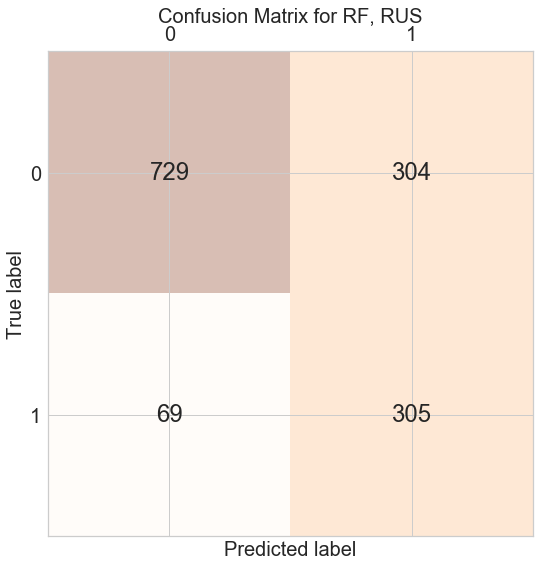

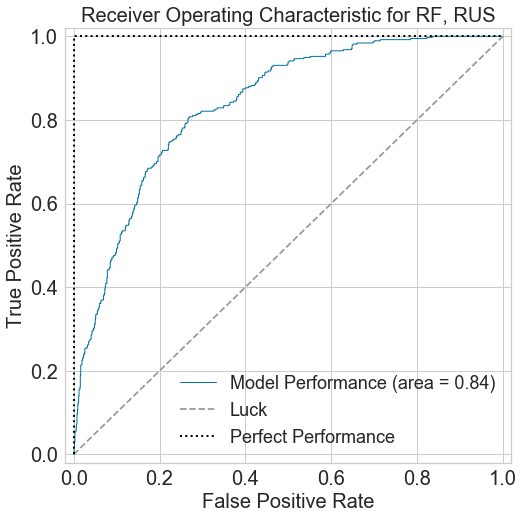

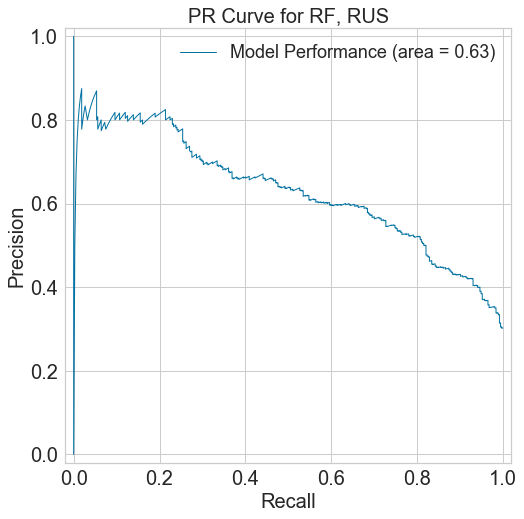

In [11]:
result(RFrus, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="RF, RUS")

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.3s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.0s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.6s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.9s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


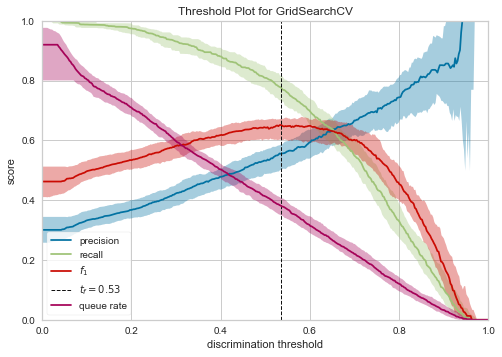

In [12]:
visualizer = DiscriminationThreshold(RFrus)
visualizer.fit(X_train,y_train)
visualizer.poof()

# Random Forest - Scaling, Using Class Weight

In [12]:
%%time
# Steps for pipeline
steps = [("scaler", MinMaxScaler(feature_range=(0,1))),
         ("model", RandomForestClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50, 70, 100, 200, 500, 700, 1000],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [1, 5, 10, 20, 30],
                  model__class_weight = ['balanced'])
# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
RFcw = GridSearchCV(pipe, 
                    param_grid = param_grid, 
                    verbose = 3,
                    cv = cv,
                    n_jobs=-1,
                    scoring='average_precision',
                    iid=False)

# Training using CV
RFcw.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.2min finished


CPU times: user 4.55 s, sys: 382 ms, total: 4.93 s
Wall time: 9min 16s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_node...
         

In [15]:
RFcw.best_params_

{'model__class_weight': 'balanced',
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 30,
 'model__n_estimators': 50}

#####################
Test data
#####################
F1:  0.6203319502074689
Cohen Kappa:  0.4372172217680771
Brier:  0.2601279317697228
LogLoss:  0.49539950336969757
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



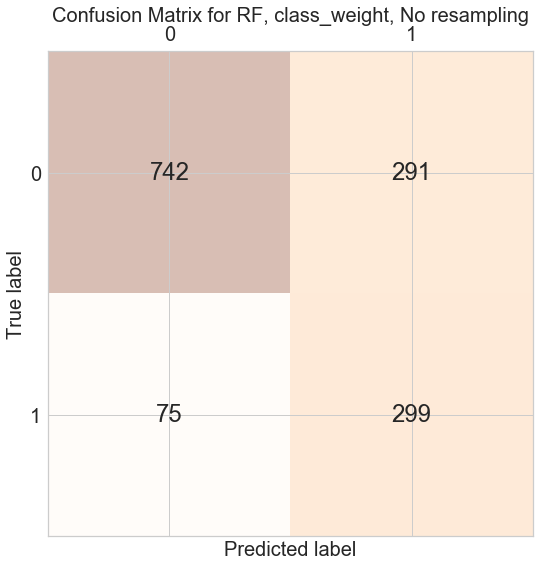

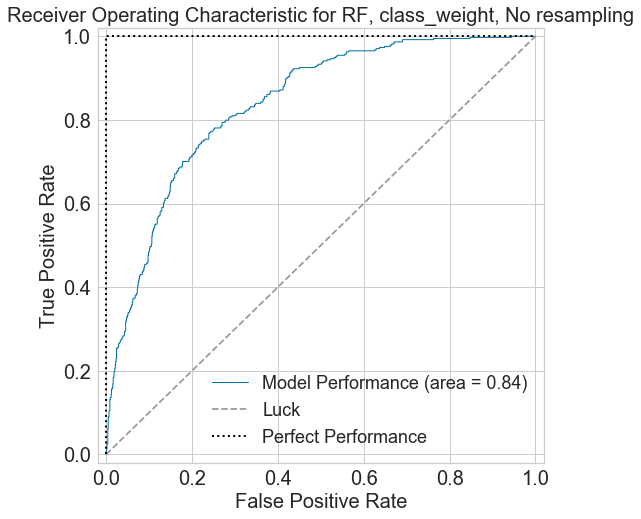

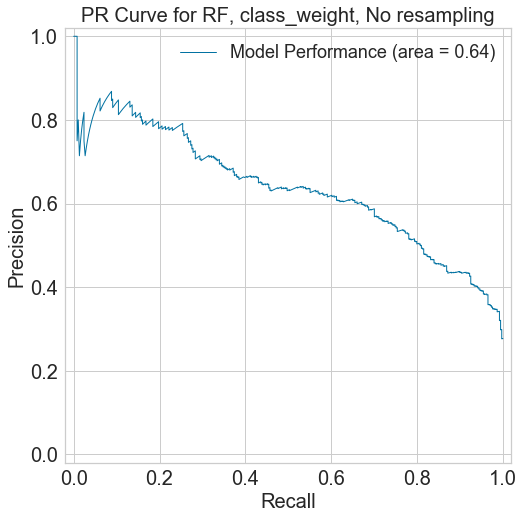

In [15]:
result(RFcw, X_train, y_train, X_test, y_test, 
       train_result=False, clf_name="RF, class_weight, No resampling")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.8s finished


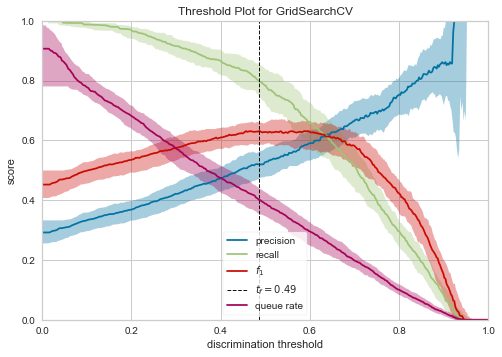

In [17]:
visualizer = DiscriminationThreshold(RFcw)
visualizer.fit(X_train,y_train)
visualizer.poof()

# Random Forest  - Over Sampling, Scaling 

In [14]:
%%time
# Steps for pipeline
steps = [("smote", SMOTE(random_state=30)),
         ("scaler",MinMaxScaler(feature_range=(0,1))),
         ("model", RandomForestClassifier(random_state=40))]
pipe = pl(steps)

# Parameters
param_grid = dict(model__n_estimators = [50, 70, 100, 200, 500, 700, 1000],
                  model__max_features = ['sqrt', 'log2'],
                  model__min_samples_leaf = [1, 5, 10, 20, 30])

# For CV in grid search
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 20)

# Setting up the grid search
RFsmote = GridSearchCV(pipe, 
                       param_grid = param_grid, 
                       verbose = 4,
                       cv = cv,
                       n_jobs=-1,
                       scoring='average_precision',
                       iid=False)

# Training using CV
RFsmote.fit(X_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 16.1min finished


CPU times: user 4.49 s, sys: 433 ms, total: 4.92 s
Wall time: 16min 7s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=20, test_size=0.2,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=30,
                                              sampling_strategy='auto')),
                                       ('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0...
                                                               n_jobs=None,
                                                               oob_score=Fals

In [13]:
RFsmote.best_params_

NameError: name 'RFsmote' is not defined

#####################
Test data
#####################
F1:  0.5919395465994962
Cohen Kappa:  0.43229248391652275
Brier:  0.2302771855010661
LogLoss:  0.4480549337644573
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1033
           1       0.56      0.63      0.59       374

    accuracy                           0.77      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.77      0.77      1407



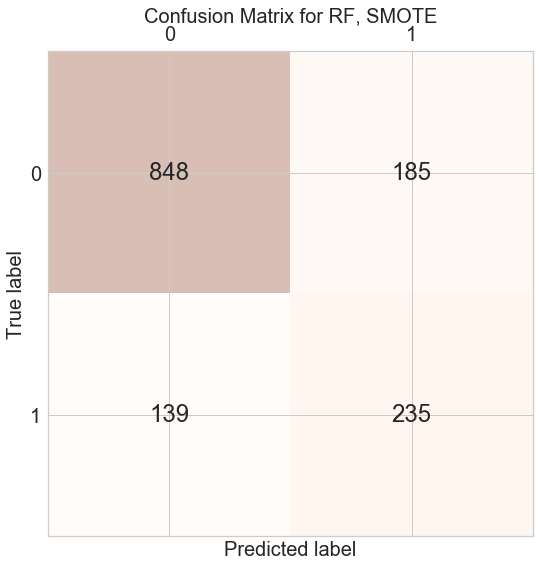

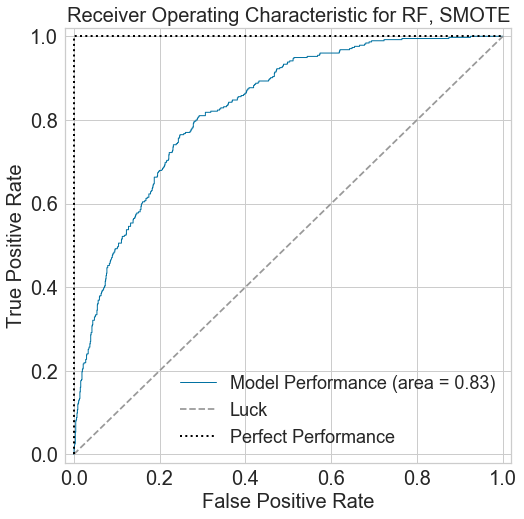

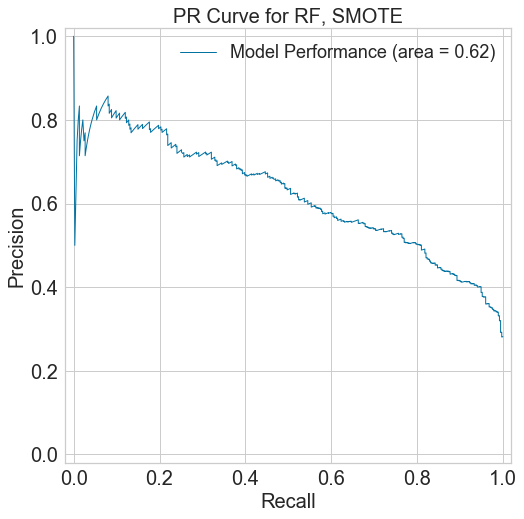

In [20]:
result(RFsmote, X_train, y_train, X_test, y_test, train_result=False, clf_name="RF, SMOTE")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.4s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.8s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.2s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.1s finished


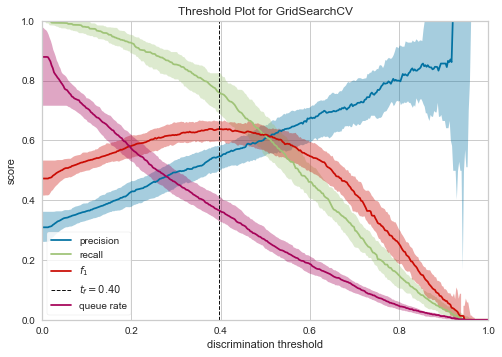

In [22]:
visualizer = DiscriminationThreshold(RFsmote)
visualizer.fit(X_train,y_train)
visualizer.poof()